# Example: Deploying a Classifier
This notebook shows how one might use a previously trained deep learning model to classify a subset of the ISBI 2012 data set.  This assumes you have access to the ISBI 2012 data, which is available as a download from the [ISBI challenge website](http://brainiac2.mit.edu/isbi_challenge/home) or via an ndparse database call (see example below).  It also assumes you have a local copy of trained weights for a Keras deep learning model; one example weights file is checked into this repository which will provide reasonable (but not state-of-the-art) results.  You will also need to have [Keras](http://keras.io/) (along with a suitable backend - we use Theano) installed.

---

## Step 1: setup python environment

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os, copy, logging, socket, time

# TODO: a cleaner way to do this??
sys.path.append(os.path.join('..', 'ndparse', 'algorithms'))

import numpy as np
import pylab as plt

import nddl

try:
    logger
except:
    # do this precisely once
    logger = logging.getLogger("deploy_model")
    logger.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter('[%(asctime)s:%(name)s:%(levelname)s]  %(message)s'))
    logger.addHandler(ch)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 2: Load data and model weights

In [17]:
print rawData.shape

(1024, 1024, 100)


Running on system: gpucluster0
time elapsed is: 5.7860250473 seconds
Test data shape is: (100, 1, 1024, 1024)


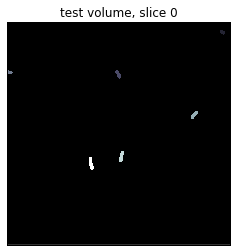

In [23]:
print "Running on system: %s" % socket.gethostname()

# Load previously trained CNN weights
weightsFile = './isbi2012_weights_e025.h5'


if True:
    # Using a local copy of data volume
    inDir = '/home/pekalmj1/Data/EM_2012'
    Xtrain = nddl.load_cube(os.path.join(inDir, 'train-volume.tif'))
    Ytrain = nddl.load_cube(os.path.join(inDir, 'train-labels.tif'))
    Xtest = nddl.load_cube(os.path.join(inDir, 'test-volume.tif'))
    
else:
    # example of using ndio database call
    import ndio.remote.neurodata as ND
    tic = time.time()
    
    nd = ND()
    
    token = 'kasthuri11cc'
    channel = 'image'
    xstart, xstop = 5472, 6496
    ystart, ystop = 8712, 9736
    zstart, zstop = 1000, 1100
    res = 1
    
    Xtest = nd.get_cutout(token, channel, xstart, xstop, ystart, ystop, zstart, zstop, resolution=res)
    Xtest = np.transpose(rawData, [2, 0, 1])
    Xtest = Xtest[:, np.newaxis, :, :]  # add a channel dimension
    print 'time elapsed is: {} seconds'.format(time.time()-tic)

    
# show some details.  Note that data tensors are assumed to have dimensions:
#   (#slices, #channels, #rows, #columns)
#
print('Test data shape is: %s' % str(Xtest.shape))
plt.imshow(Xtest[0,0,...], interpolation='none', cmap='bone')
plt.title('test volume, slice 0')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()

## Step 3: Deploy the model

In [11]:
# In the interest of time, only deploy on one slice (z-dimension) of the test volume 
# *and* only evaluate a subset of the pixels in that slice.
#
# Note: depending upon your system (e.g. CPU vs GPU) this may take a few minutes...
#
tic = time.time()
P0 = nddl.deploy_model(Xtest, weightsFile, slices=[0,], evalPct=.1, log=logger)
print "Time to deploy: %0.2f sec" % (time.time() - tic)

# The shape of the probability estimate tensor is:
#    (#slices, #classes, #rows, #cols)
print('Class probabilities shape: %s' % str(P0.shape))

[2016-04-04 09:50:38,162:deploy_model:WARNING]  No output file specified - are you sure this is what you want?
[2016-04-04 09:50:38,168:deploy_model:INFO]  X volume dimensions: (1, 1, 512, 512)
INFO:deploy_model:X volume dimensions: (1, 1, 512, 512)
[2016-04-04 09:50:38,171:deploy_model:INFO]  X values min/max:    0, 1
INFO:deploy_model:X values min/max:    0, 1
[2016-04-04 09:50:38,172:deploy_model:INFO]  initializing CNN...
INFO:deploy_model:initializing CNN...
[2016-04-04 09:51:01,638:deploy_model:INFO]  evaluating volume...
INFO:deploy_model:evaluating volume...
[2016-04-04 09:51:02,968:deploy_model:INFO]  after masking, will evaluate 10.00% of data
INFO:deploy_model:after masking, will evaluate 10.00% of data
[2016-04-04 09:51:03,033:deploy_model:INFO]    last pixel [  0   1 473] (0.38% complete)
INFO:deploy_model:  last pixel [  0   1 473] (0.38% complete)
[2016-04-04 09:51:17,907:deploy_model:INFO]  Complete!
INFO:deploy_model:Complete!


Time to deploy: 39.75 sec
Class probabilities shape: (1, 2, 512, 512)


## Step 4: Postprocessing

Note: in order to do actual science, one would use more sophisticated postprocessing (and also put more effort into the CNN design).

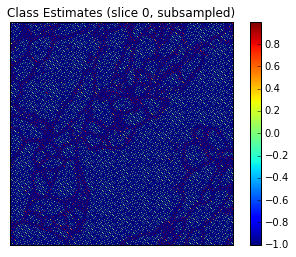

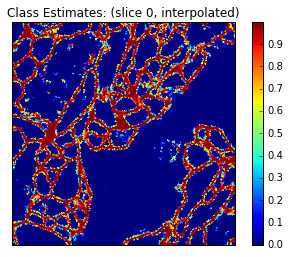

In [12]:
# Use a simple interpolation scheme to fill in "missing" values 
# (i.e. those pixels we did not evaluate using the CNN).
# 
Pint = nddl.interpolate_nn(P0)

# visualize
plt.imshow(P0[0,0,...]); plt.colorbar()
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.title('Class Estimates (slice 0, subsampled)')
plt.show()

plt.imshow(Pint[0,0,...]); plt.colorbar()
plt.title('Class Estimates: (slice 0, interpolated)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()


### Notes
It helps to have a reasonably good GPU when running this example.  e.g. I run this notebook remotely on our GPU cluster using the instructions provided [here](http://www.datasciencebytes.com/bytes/2015/12/18/using-jupyter-notebooks-securely-on-remote-linux-machines/).

On the cluster, navigate to the toplevel directory of this repository and do:
```
    jupyter notebook --no-browser &
```

On the local machine, establish an ssh session:
```
    ssh -i ~/.ssh/redd-gpucluster.pekalmj1.rsa -NL 8157:localhost:8888 pekalmj1@gpucluster0
```

On the local machine, point browser to:
```
    http://localhost:8157
```